In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys
import dill

import json
import tqdm

import support_functions as sf

In [2]:
directory = 'calib_data/'
sys.path.insert(0, directory)

## Parameters

In [3]:
FRAC = [(1., 1.), (.1, .6), (.05, .5), (0., 0.)]
a_range = [0.1, 5]
b_range = [30, 100]
c_range = [-1000, -10]
t_range = [5, 10]

p_norm = [
    float(np.mean(a_range)),
    float(np.mean(b_range)),
    float(np.mean(c_range)),
    float(np.mean(t_range))
]

parameters = {
    'frac': FRAC,
    'a_range': a_range,
    'b_range': b_range,
    'c_range': c_range,
    't_range': t_range,
    'p_norm': p_norm
}

with open(directory + 'parameters.json', 'w') as f:
    json.dump(parameters, f)

## Calibration function distribution

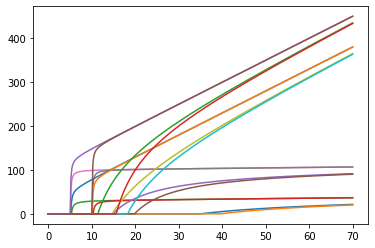

In [4]:
x = np.linspace(0, 70, 1000)
for a in a_range:
    for b in b_range:
        for c in c_range:
            for t in t_range:
                plt.plot(x, sf.energy_to_tot(x, a, b, c, t))

## Generate data

In [24]:
def gen_spectrum(sources, data_dict, frac,
        a_range=(0.5, 5.5), b_range=(5, 12),
        c_range=(-80, -30), t_range=(-2.5, -1),
        N_range=(5000, 100000), sigma_params_0=[2.49, 0.09, 1.06],
        p_norm=[2.5, 8.5, -55, -1.75], batch_size=1
    ):
    while True:
        batch_out, params_out = [], []
        for _ in tqdm.tqdm(range(batch_size)):
            N = np.random.randint(*N_range)
            fr = []
            for idx in range( len(sources) ):
                fr.append( np.random.uniform(*frac[idx]) )
            fr = np.asarray( fr )

            data_smear = []
            for idx, source in enumerate( sources ):
                data = np.random.choice(data_dict[source], int(N * fr[idx] / np.sum(fr)), replace=True)
                data_smear += data.tolist()
            data_smear = np.asarray(data_smear)

            if sigma_params_0 is not None:
                sigma_params_0 = np.asarray(sigma_params_0)
                sigma_params = np.random.normal(sigma_params_0, 0.1*sigma_params_0)
                data_smear = sf.smear_spectrum(data_smear, sigma_params)

            p = np.full(4, 10)
            while energy_to_tot(np.asarray([70]), *p) > 400:
                a = np.random.uniform(*a_range)
                b = np.random.uniform(*b_range)
                c = np.random.uniform(*c_range)
                t = np.random.uniform(*t_range)
                p = [a, b, c, t]
                THL = sf.get_thl(*p)
            params_out.append( p )

            hist, _ = np.histogram(
                sf.energy_to_tot(data_smear[data_smear >= THL], *p),
                bins=np.arange(401)
            )
            # plt.hist(dataSmear[dataSmear >= THL], bins=300, histtype='step')

            hist = hist.astype(float)
            hist /= np.max(hist)
            batch_out.append( hist )
        batch_out, params_out = np.asarray(batch_out), np.asarray(params_out) / np.asarray(p_norm)
        yield batch_out.reshape(np.append(batch_out.shape, 1)), params_out

### Large Pixels

#### Load data

In [5]:
sources = ['Am', 'Mo', 'Sn', 'Ge']
data_dict = {}
# Load simulation
for source in sources:
    data_dict[source] = json.load(
        open(directory + 'XRay_%s_out.json' % source)
    )

#### Exemplary plots

100%|██████████| 1024/1024 [00:18<00:00, 55.58it/s]


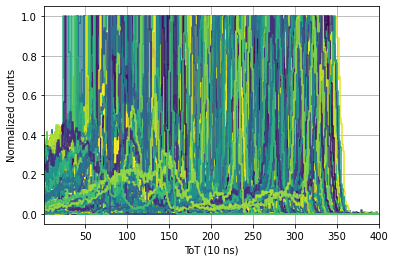

In [66]:
spec_gen = gen_spectrum(
    sources, data_dict, FRAC,
    a_range=a_range, b_range=b_range,
    c_range=c_range, t_range=t_range, batch_size=1024
)

hist = next(spec_gen)[0]
bins = np.arange(400)

color = [sf.get_color('viridis', len(hist), h_idx) for h_idx in range(len(hist))]
np.random.shuffle(color)

for h_idx, h in enumerate(hist):
    plt.step(bins, h.flatten(), color=color[h_idx])
plt.grid()
plt.xlim(1, 400)
plt.xlabel('ToT (10 ns)')
plt.ylabel('Normalized counts')
plt.show()

Text(0, 0.5, 'Normalised counts')

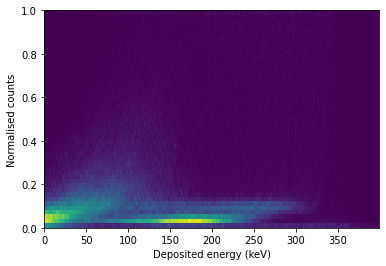

In [67]:
x_total = np.asarray(bins.tolist()*len(hist)).flatten()
y_total = hist.flatten()
filt = y_total > 0.

plt.hist2d(x_total[filt], y_total[filt], bins=[bins, np.linspace(0, 1, 50)]);
plt.xlabel('Deposited energy (keV)')
plt.ylabel('Normalised counts')

#### Generate spectra

In [68]:
spec_gen = gen_spectrum(sources, data_dict, FRAC, 
    a_range=a_range, b_range=b_range,
    c_range=c_range, t_range=t_range,
    p_norm=p_norm, batch_size=40000)
x_train, y_train = next(spec_gen)

spec_gen = gen_spectrum(sources, data_dict, FRAC, 
    a_range=a_range, b_range=b_range,
    c_range=c_range, t_range=t_range,
    p_norm=p_norm, batch_size=5000)
x_val, y_val = next(spec_gen)

100%|██████████| 5000/5000 [01:33<00:00, 53.76it/s]


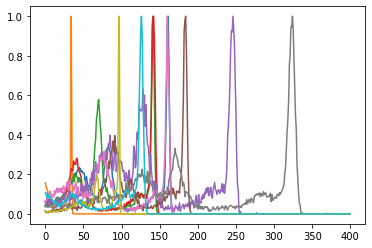

In [69]:
for idx in range(10):
    plt.plot(x_eval[idx])

#### Dump

In [71]:
sf.dump_json(directory + 'train.json', x_train, y_train)
sf.dump_json(directory + 'valid.json', x_val, y_val)